# Lecture 9 : Dynamic Memory Allocation

## Clone the materials repo on github to access datafiles.

In [1]:
!git clone https://github.com/jasonrwilson/cmda3634_materials

Cloning into 'cmda3634_materials'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 108 (delta 1), reused 1 (delta 1), pack-reused 103
Receiving objects: 100% (108/108), 1.09 MiB | 6.75 MiB/s, done.
Resolving deltas: 100% (55/55), done.


## Copy the lecture 9 materials into our local workspace.

In [2]:
!cp cmda3634_materials/L09/* .

# Part 1 : Sieve of Eratosthenes

## The Sieve of Erathostenes is a method for finding all prime numbers below a certain number.  

## The wiki page https://en.wikipedia.org/wiki/Sieve_of_Eratosthenes has a graphical demo showing how the algorithm works.  

## We use an integer array of size n+1 to keep track of which numbers are prime.  

## In the first version we put the array on the stack which limits how big of an n we can handle.  

In [3]:
%%writefile count_primes.c
#include <stdio.h>
#include <stdlib.h>

int main (int argc, char* argv[]) {

    // count number of primes <= n
    // where n is read from the command line
    if (argc < 2) {
        printf ("command usage: %s %s\n",argv[0],"n");
        return 1;
    }
    int n = atoi(argv[1]);

    // initially assume all integers >= 2 are prime
    // note that we ignore is_prime[0] and is_prime[1]
    int is_prime[n+1];
    for (int i = 2; i <= n; i++) {
        is_prime[i] = 1;
    }

    // mark non-primes <= n using Sieve of Eratosthenes
    for (int d=2;d*d<=n;d++) {
        // if d is prime, then mark multiples of d as non-prime
        // suffices to consider multiples d*d, d*d+d, d*d+2d, ...
        if (is_prime[d]) {
            for (int c=d*d;c<=n;c+=d) {
                is_prime[c] = 0;
            }
        }
    }

    // count primes
    int primes = 0;
    for (int i = 2; i <= n; i++) {
        if (is_prime[i]) {
            primes++;
        }
    }
    printf ("The number of primes <= %d is %d",n,primes);
}

Writing count_primes.c


In [4]:
!gcc -o count_primes count_primes.c

In [5]:
!./count_primes 10

The number of primes <= 10 is 4

In [6]:
!time ./count_primes 1000000

The number of primes <= 1000000 is 78498
real	0m0.018s
user	0m0.008s
sys	0m0.004s


In [7]:
!time ./count_primes 10000000

/bin/bash: line 1:   322 Segmentation fault      (core dumped) ./count_primes 10000000

real	0m0.053s
user	0m0.000s
sys	0m0.044s


## In version 1 we put the array on the stack which severely limits how big of an n we can handle.  

## In order to handle larger n, we will need to use **dynamic memory allocation**.  

## There are **two pools of memory** that our C programs can use.  

## The first pool of memory is called the **stack** which has a very limited size.  

## If you declare an array variable using the notation *int a[100]* then the 400 bytes of memory (an int is 4 bytes) for that array is allocated on the **stack**.  

## The second pool of memory is called the **heap** which has a much larger size than the **stack**.

## Memory on the heap is accessed very differently than memory on the stack.  

## To use heap memory, we need to ask the **memory manager** for a certain number of bytes.  If those bytes are available, then the **memory manager** will return to us a pointer to the beginning of our requested memory.

## We need to **free** up our requested memory when we no longer require it.

## We interface with the **memory manager** using C functions such as **malloc**, **calloc**, and **free**.

## Here is an example illustrating the basics of dynamic memory allocation on the heap.


In [8]:
%%writefile heap.c
#include <stdio.h>
#include <stdlib.h>

int main () {

    // allocate an array of 5 integers on the stack
    int a[5];

    // allocate an array of 5 integers on the heap
    // malloc stands for "memory allocation"
    // memory allocated using malloc is not initialized.
    int* b = (int*)malloc(5*sizeof(int));

    // allocate an array of 5 integers on the stack
    // and initialize the array to contain all 0s.
    int c[5] = { 0 };

    // allocate an array of 5 integers on the heap
    // and initialize the array to contain all 0s.
    // calloc stands for "clear allocate"
    // note that the interface to calloc differs slightly
    int* d = (int*)calloc(5,sizeof(int));

    // all of these arrays can be used in the same way
    a[2] = 10;
    b[2] = 2*a[2];
    c[2] += a[2]+b[2];
    d[2] += c[2]+a[2];
    printf ("%d %d %d %d\n",a[2],b[2],c[2],d[2]);

    // Memory for stack variables is automatically
    // freed when it is no longer needed.
    // Memory for heap variables is freed manually.
    // Do not continue to use memory after it has been freed!
    free(b);
    free(d);
}

Writing heap.c


In [9]:
!gcc -o heap heap.c

In [10]:
!./heap

10 20 30 40


## Here is a version of our code that counts primes using an array on the heap.

In [11]:
%%writefile count_primes_heap.c
#include <stdio.h>
#include <stdlib.h>

int main (int argc, char* argv[]) {

    // count number of primes <= n
    // where n is read from the command line
    if (argc < 2) {
        printf ("command usage: %s %s\n",argv[0],"n");
        return 1;
    }
    int n = atoi(argv[1]);

    // initially assume all integers >= 2 are prime
    // note that we ignore is_prime[0] and is_prime[1]
    // we dynamically allocate the array using malloc
    // It is a good habit to check the return value of
    // malloc to ensure the allocation was successful.
    // This will be especially important for GPU computing
    // where the amount of memory is relatively limited!
    int* is_prime = (int*)malloc((n+1)*sizeof(int));
    if (is_prime == NULL) {
        printf ("failed to allocate is_prime array!\n");
        return 1;
    }
    for (int i = 2; i <= n; i++) {
        is_prime[i] = 1;
    }

    // mark non-primes <= n using Sieve of Eratosthenes
    for (int d=2;d*d<=n;d++) {
        // if d is prime, then mark multiples of d as non-prime
        // suffices to consider multiples d*d, d*d+d, d*d+2d, ...
        if (is_prime[d]) {
            for (int c=d*d;c<=n;c+=d) {
                is_prime[c] = 0;
            }
        }
    }

    // count primes
    int primes = 0;
    for (int i = 2; i <= n; i++) {
        if (is_prime[i]) {
            primes++;
        }
    }
    printf ("The number of primes <= %d is %d",n,primes);

    // free the dynamically allocated array
    free(is_prime);
}


Writing count_primes_heap.c


## Let's switch on the optimizing compiler for better performance.

In [12]:
!gcc -O3 -o count_primes_heap count_primes_heap.c

In [13]:
!time ./count_primes_heap 100000000

The number of primes <= 100000000 is 5761455
real	0m2.383s
user	0m1.531s
sys	0m0.150s


## Let's try n equal to one billion.

## In this case our **is_prime** array is of size 4 billion bytes or 4 Gigabytes!

In [14]:
!time ./count_primes_heap 1000000000

The number of primes <= 1000000000 is 50847534
real	0m19.327s
user	0m17.619s
sys	0m1.351s


## By contrast, the stack size is 8192 kilobytes which is roughly 8 Megabytes.

In [15]:
!ulimit -s

8192


# Part 2 : Matrix Vector Multiplication

## Working with two-dimensional arrays in C is similar to other languages such as Java and Python.

## Here is an example program that multiples a $4 \times 3$ matrix by a vector in $\mathbb{R}^3$.

In [16]:
%%writefile matvec.c
#include <stdio.h>

int main () {
    int m = 4; // m - number of rows of A
    int n = 3; // n - number of columns of A
    double A[4][3] = { { 0.2, 1, 2 }, { 1, 2.5, 3 }, { 4, 5.8, 6 }, { 7, 8, 9.3 } };
    double x[3] = { 1, 1, 1 };
    double b[4] = { 0 };
    for (int i=0;i<m;i++) {
        for (int j=0;j<n;j++) {
            b[i] += A[i][j]*x[j];
        }
    }
    printf ("b = { %.2f, %.2f, %.2f, %.2f }\n",b[0],b[1],b[2],b[3]);
}

Writing matvec.c


In [17]:
!gcc -o matvec matvec.c

In [18]:
!./matvec

b = { 3.20, 6.50, 15.80, 24.30 }


## Here is the second version of matrix vector multiplication that uses a dot product function.  

## In particular, note that A[i] is a **pointer** to the $i^{th}$ row of the $4 \times 3$ matrix A.

In [19]:
%%writefile matvec_dot.c
#include <stdio.h>

double vec_dot_prod (double u[], double v[], int dim) {
    double dot_prod = 0;
    for (int i=0;i<dim;i++) {
        dot_prod += u[i]*v[i];
    }
    return dot_prod;
}

int main () {
    int m = 4; // m - number of rows of A
    int n = 3; // n - number of columns of A
    double A[4][3] = { { 0.2, 1, 2 }, { 1, 2.5, 3 }, { 4, 5.8, 6 }, { 7, 8, 9.3 } };
    double x[3] = { 1, 1, 1 };
    double b[3];
    for (int i=0;i<m;i++) {
        b[i] = vec_dot_prod(A[i],x,n); // A[i] is a pointer to the ith row of A
    }
    printf ("b = { %.2f, %.2f, %.2f, %.2f }\n",b[0],b[1],b[2],b[3]);
}

Writing matvec_dot.c


In [20]:
!gcc -o matvec_dot matvec_dot.c

In [21]:
!./matvec_dot

b = { 3.20, 6.50, 15.80, 24.30 }


# Part 3 : Finding the Extreme Pair of Points in $\mathbb{R}^n$

## To find the extreme pair we will need to maximize $$\| \mathbf{u} - \mathbf{v} \|$$

## which is equivalent to maximizing $$\| \mathbf{u} - \mathbf{v} \|^2$$

## We will store the set of vectors in $\mathbb{R}^n$ using a two-dimensional array.

## Note that we make use of the vector functions that we wrote in the previous lecture.

## Note on line 18 that data[i] is a pointer to the $i^{th}$ row of our data matrix.

## In other words, data[i] points to the $i^{th}$ point of our dataset.

In [22]:
%%writefile extreme.c
#include <stdio.h>
#include <math.h>
#include "vec.h"

int main () {

    // read the number of points and the dimension of each point
    int num_points, dim;
    if (scanf("%*c %d %d",&num_points, &dim) != 2) {
        printf ("error reading the number of points and the dimension\n");
        return 1;
    }

    // Read vectors from stdin and store them in a 2d array
    double data[num_points][dim];
    for (int i=0;i<num_points;i++) {
        if (vec_read_stdin(data[i],dim) != dim) {
            printf ("error reading the next point from stdin\n");
            return 1;
        }
    }

    // find the extreme pair
    double max_dist_sq = 0;
    int extreme1, extreme2;
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            double dist_sq = vec_dist_sq(data[i],data[j],dim);
            if (dist_sq > max_dist_sq) {
                max_dist_sq = dist_sq;
                extreme1 = i;
                extreme2 = j;
            }
        }
    }

    // output the results
    printf ("Extreme Distance = %.2f\n",sqrt(max_dist_sq));
    printf ("Extreme Pair = %d %d\n",extreme1,extreme2);
}

Writing extreme.c


In [23]:
!gcc -o extreme extreme.c vec.c -lm

In [24]:
!cat mnist1000.txt | ./extreme

Extreme Distance = 3797.52
Extreme Pair = 121 426


In [25]:
!cat mnist1000.txt | python3 mnist.py extreme.png 121 426

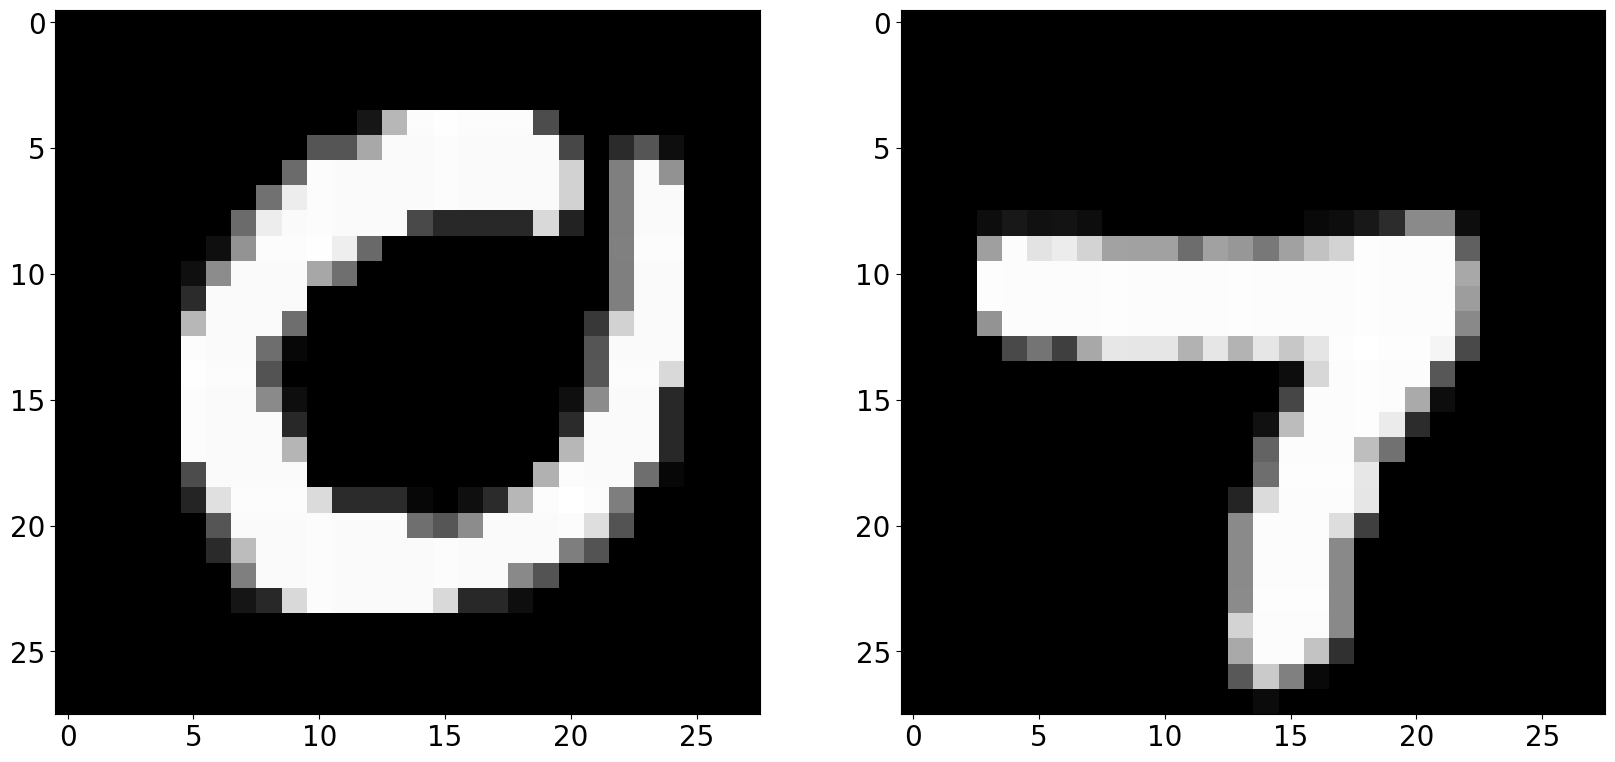

In [26]:
from IPython import display
display.Image("extreme.png")

In [27]:
!cat mnist2000.txt | ./extreme_v1

/bin/bash: line 1: ./extreme_v1: No such file or directory


## What caused the segmentation fault?  

## Hint 1: How many bytes is the *double data[2000][784]* array?

## Hint 2: Remember that the stack size is 8192 kilobytes.  

In [28]:
!ulimit -s

8192


## In order to handle large datasets we will need to move the 2d data array from the stack to the heap.

## One big obstacle is that when using the heap we can only get a pointer to a 1d array when using **malloc** or **calloc**.

## We can work around this limitation by **flattening** the 2d array into a 1d array.

# Part 4 : Matrix Vector Multiplication using a "Flat" 2d array to store $A$

## Consider the following 2d array.

$$
\begin{array}{|c|c|c|c|}
        \hline
        5 & -2 & 7 & 10 \\
        \hline
        -6 & 1 & 4 & 8 \\
          \hline
        9 & 0 & -5 & 3 \\
        \hline
        \end{array}
$$

## We could **flatten** the 2d array into a 1d array of size $12$ using **row-major order**.
        
$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|}
            \hline
           5 & -2 & 7 & 10 & -6 & 1 & 4 & 8 & 9 & 0 & -5 & 3 \\
            \hline
            \end{array}
$$

## We could also **flatten** the 2d array into a 1d array of size $12$ using **column-major order**.
        
$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|}
            \hline
           5 & -6 & 9 & -2 & 1 & 0 & 7 & 4 & -5 & 10 & 8 & 3 \\
            \hline
            \end{array}
$$

## When storing matrices as one-dimensional arrays in class we will use **row-major order** unless otherwise specified.  


## We can visualize how a 2d array is flattened into a 1d array using **row-major order** by putting the 1d indices into the 2d array.

$$
\begin{array}{|c|c|c|c|}
        \hline
        0 & 1 & 2 & 3 \\
        \hline
        4 & 5 & 6 & 7 \\
          \hline
        8 & 9 & 10 & 11 \\
        \hline
        12 & & & ? \\
        \hline
        & & & \\
        \hline
        & & & \\
        \hline
        & & & \\
        \hline
        & ?? & & \\
        \hline
        & & & \\
        \hline
        \end{array}
$$

## What index should go in the ? blank?

## **Answer**:

## What index should go in the ?? blank?

## **Answer**:

## Given a 2d array with $9$ rows and $4$ columns, give a formula for the 1d array index for the entry in row i and column j of the 2d array.

## **Answer**:

## Given a 2d array with $m$ rows and $n$ columns, give a formula for the 1d array index for the entry in row i and column j of the 2d array.

## **Answer**:



## Here is a matrix vector mult using a "flat" 2d array to store the matrix A.

In [29]:
%%writefile matvec_flat.c
#include <stdio.h>

int main () {
    int m = 4; // number of rows of A
    int n = 3; // number of columns of A
    double A[4*3] = { 0.2, 1, 2, 1, 2.5, 3, 4, 5.8, 6, 7, 8, 9.3 };
    double x[3] = { 1, 1, 1 };
    double b[4] = { 0 };
    for (int i=0;i<m;i++) {
        for (int j=0;j<n;j++) {
            // i*n+j is the 1d index of the row i column j entry of A
            b[i] += A[i*n+j]*x[j];
        }
    }
    printf ("b = { %.2f, %.2f, %.2f, %.2f }\n",b[0],b[1],b[2],b[3]);
}

Writing matvec_flat.c


In [30]:
!gcc -o matvec_flat matvec_flat.c

In [31]:
!./matvec_flat

b = { 3.20, 6.50, 15.80, 24.30 }


## Dot product version of matrix vector mult using a "flat" 2d array to store the matrix A.

In [32]:
%%writefile matvec_dot_flat.c
#include <stdio.h>

double vec_dot_prod (double u[], double v[], int dim) {
    double dot_prod = 0;
    for (int i=0;i<dim;i++) {
        dot_prod += u[i]*v[i];
    }
    return dot_prod;
}

int main () {
    int m = 4; // number of rows of A
    int n = 3; // number of columns of A
    double A[4*3] = { 0.2, 1, 2, 1, 2.5, 3, 4, 5.8, 6, 7, 8, 9.3 };
    double x[3] = { 1, 1, 1 };
    double b[3];
    for (int i=0;i<m;i++) {
        // &(A[i*n]) is a pointer to the ith row of A
        b[i] = vec_dot_prod(&(A[i*n]),x,n); // A+i*n also works!
    }
    printf ("b = { %.2f, %.2f, %.2f, %.2f }\n",b[0],b[1],b[2],b[3]);
}

Writing matvec_dot_flat.c


In [33]:
!gcc -o matvec_dot_flat matvec_dot_flat.c

In [34]:
!./matvec_dot_flat

b = { 3.20, 6.50, 15.80, 24.30 }


# Part 5 : Finding the Extreme Pair of a **large dataset** of points in $\mathbb{R}^n$

## As a first step in our quest to use the heap to store the 2d data array, here is a version of **extreme** that uses a flat 2d array.  

## Once we **flatten** the 2d array into a 1d array it will be simple to move the dataset from the stack to the heap.

In [35]:
%%writefile extreme_flat.c
#include <stdio.h>
#include <math.h>
#include "vec.h"

int main () {

    // read the number of points and the dimension of each point
    int num_points, dim;
    if (scanf("%*c %d %d",&num_points, &dim) != 2) {
        printf ("error reading the number of points and the dimension\n");
        return 1;
    }

    // Read vectors from stdin and store them in a flat 2d array
    double data[num_points*dim]; // flat 2d array
    for (int i=0;i<num_points;i++) {
        // data+i*dim is a pointer to the ith data point
        if (vec_read_stdin(data+i*dim,dim) != dim) {
            printf ("error reading the next point from stdin\n");
            return 1;
        }
    }

    // find the extreme pair
    double max_dist_sq = 0;
    int extreme1, extreme2;
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            // data+i*dim is a pointer to the ith data point
            // data+j*dim is a pointer to the jth data point
            double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
            if (dist_sq > max_dist_sq) {
                max_dist_sq = dist_sq;
                extreme1 = i;
                extreme2 = j;
            }
        }
    }

    // output the results
    printf ("Extreme Distance = %.2f\n",sqrt(max_dist_sq));
    printf ("Extreme Pair = %d %d\n",extreme1,extreme2);
}

Writing extreme_flat.c


In [36]:
!gcc -o extreme_flat extreme_flat.c vec.c -lm

In [37]:
!cat mnist1000.txt | ./extreme_flat

Extreme Distance = 3797.52
Extreme Pair = 121 426


## Now we are ready for the version of extreme that uses the heap to store the dataset.

In [38]:
%%writefile extreme_heap.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "vec.h"

int main () {

    // read the number of points and the dimension of each point
    int num_points, dim;
    if (scanf("%*c %d %d",&num_points, &dim) != 2) {
        printf ("error reading the number of points and the dimension\n");
        return 1;
    }

    // Read vectors from stdin and store them in a flat 2d array
    double* data = (double*)malloc(num_points*dim*sizeof(double));
    if (data == NULL) {
        printf ("failed to allocate data array!\n");
        return 1;
    }

    for (int i=0;i<num_points;i++) {
        // data+i*dim is a pointer to the ith data point
        if (vec_read_stdin(data+i*dim,dim) != dim) {
            printf ("error reading the next point from stdin\n");
            return 1;
        }
    }

    // find the extreme pair
    double max_dist_sq = 0;
    int extreme1, extreme2;
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            // data+i*dim is a pointer to the ith data point
            // data+j*dim is a pointer to the jth data point
            double dist_sq = vec_dist_sq(data+i*dim,data+j*dim,dim);
            if (dist_sq > max_dist_sq) {
                max_dist_sq = dist_sq;
                extreme1 = i;
                extreme2 = j;
            }
        }
    }

    // output the results
    printf ("Extreme Distance = %.2f\n",sqrt(max_dist_sq));
    printf ("Extreme Pair = %d %d\n",extreme1,extreme2);

    // free our heap array
    free (data);
}

Writing extreme_heap.c


In [39]:
!gcc -O3 -o extreme_heap extreme_heap.c vec.c -lm

In [40]:
!time cat mnist2000.txt | ./extreme_heap

Extreme Distance = 3928.75
Extreme Pair = 1618 1895

real	0m1.623s
user	0m1.584s
sys	0m0.018s


In [41]:
!cat mnist2000.txt | python3 mnist.py extreme2.png 1618 1895

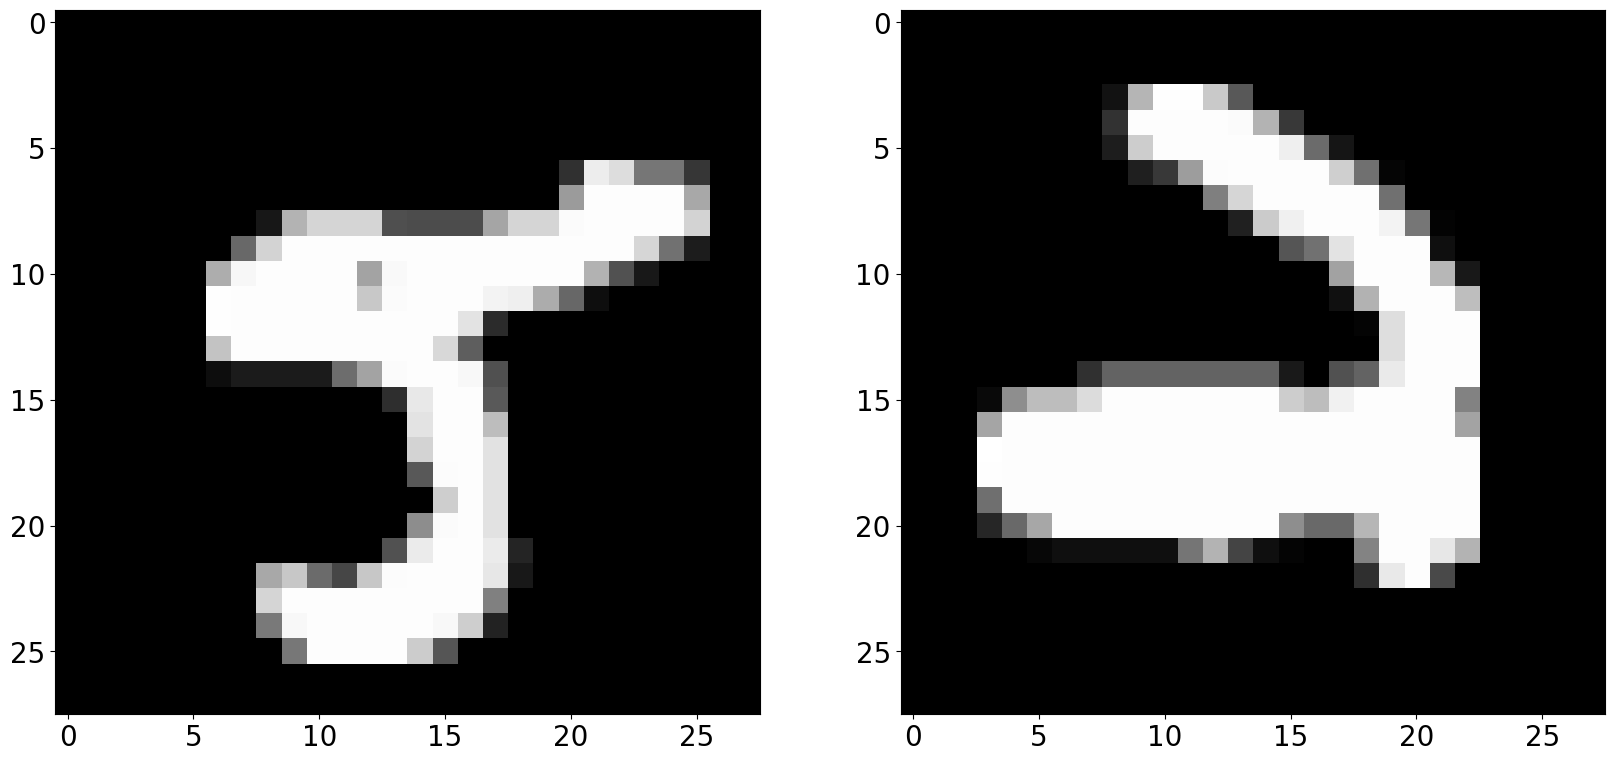

In [42]:
from IPython import display
display.Image("extreme2.png")